## Imports

In [27]:
import os
import joblib
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [2]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
origin_dim = x_train.shape[1]

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape to flat
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

x_train_flat.shape

(60000, 784)

## Pipeline

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyAE(BaseEstimator, TransformerMixin):
    def __init__(self, lat_dim=10):
        # super().__init__(**kwargs)
        self.lat_dim = lat_dim
        self.build_ae()
        
    def build_ae(self):
        inputs = tf.keras.layers.Input(shape=(784,))
        encoded = tf.keras.layers.Dense(128, activation='relu')(inputs)
        encoded = tf.keras.layers.Dense(self.lat_dim, activation='relu')(encoded)
        decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
        decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)
        self.autoencoder = tf.keras.Model(inputs, decoded)
        self.autoencoder.compile(optimizer='adam', loss='mse')

    def call(self, inputs):
        return self.autoencoder(inputs)
    
    def get_params(self, deep=True):
        return {"lat_dim": self.lat_dim}

    def set_params(self, **parameters): 
        for k, v in parameters.items():
            # self.lat_dim = v
            # break
            setattr(self, k, v) 
        self.build_ae()
        return self

    def fit(self, X, y=None, epochs=10):
        self.autoencoder.fit(X, y, epochs)
        return self

    def transform(self, X, y=None):
        return self.autoencoder.predict(X)

In [26]:
# AE
def create_autoencoder(hp):
    lat_dim_ae = hp.Int('lat_dim', min_value=4, max_value=40, step=4)
    inputs = tf.keras.layers.Input(shape=(784,))
    encoded = tf.keras.layers.Dense(128, activation='relu')(inputs)
    encoded = tf.keras.layers.Dense(lat_dim_ae, activation='relu')(encoded)
    decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
    decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

    autoencoder = tf.keras.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [ ]:
autoencoder = create_autoencoder(12)
start_time = time.time()
autoencoder.fit(x_train_flat, x_train_flat, epochs=10)
AE_train_time = time.time() - start_time

x_train_ae = autoencoder.predict(x_train_flat)
x_test_ae = autoencoder.predict(x_test_flat)
x_train_ae.shape

In [21]:
# SVD
lat_dim_svd = 12
svd = TruncatedSVD(n_components=lat_dim_svd*lat_dim_svd)

start_time = time.time()
svd.fit(x_train_ae)
# svd.fit(x_train_flat)
svd_train_time = time.time() - start_time

x_train_svd = svd.transform(x_train_ae)
x_test_svd = svd.transform(x_test_ae)
# x_train_svd = svd.transform(x_train_flat)
# x_test_svd = svd.transform(x_test_flat)
x_train_svd.shape

(60000, 144)

In [22]:
x_train_reduced = x_train_svd
x_test_reduced = x_test_svd

In [23]:
print("AE train time:", AE_train_time)
print("SVD train time:", svd_train_time)

AE train time: 34.090847969055176
SVD train time: 1.7305171489715576


## evaluation on MLPClassifier

### MLP model

In [4]:
def make_mlp_model(x_train, y_train):
    mlp_model = MLPClassifier(solver='lbfgs')
    mlp_model.fit(x_train, y_train)
    return mlp_model

### Other Functions

In [5]:
def print_model_size(model_to_save):
    file_path =  'my_model.joblib'
    joblib.dump(model_to_save, file_path)
    
    file_size_bytes = os.path.getsize(file_path)
    file_size_kb = file_size_bytes / 1024
    print(f"Розмір файлу-моделі на диску: {file_size_kb:.2f} KB")
    if os.path.isfile(file_path):
        os.remove(file_path)

In [6]:
def my_score(mlp_model1, x_test):
    start_time = time.time()
    y_pred = mlp_model1.predict(x_test)
    print(f"Час затрачений для передбачення всіх x_test({len(x_test)}) - {round(time.time() - start_time, 2)} сек")

    size_in_bytes = sys.getsizeof(mlp_model1)
    print(f"Розмір моделі в оперативній пам'яті: {size_in_bytes} байт")
    print_model_size(mlp_model1)
    
    print("classification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Матриця помилок')
    plt.xlabel('Передбачений клас')
    plt.ylabel('Справжній клас')
    plt.show()

In [7]:
def performance_evaluation(x_train, x_test):
    start_time = time.time()
    mlp_model = make_mlp_model(x_train, y_train)
    print(f"Час навчання mlp - {round(time.time() - start_time, 2)}")
    my_score(mlp_model, x_test)

### Performance evaluation - original data

Час навчання mlp - 28.337270259857178
Час затрачений для передбачення всіх x_test(10000) - 0.03600001335144043 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 625.42 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



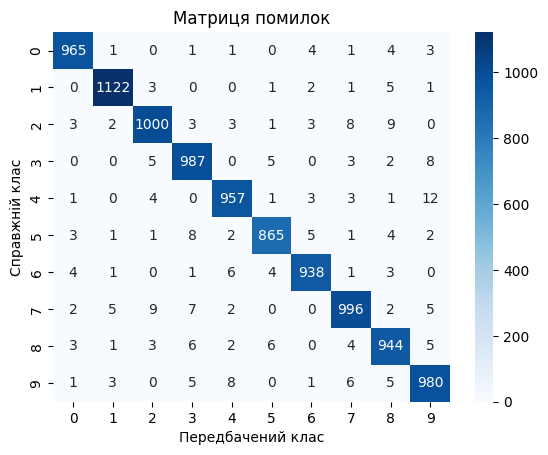

In [17]:
performance_evaluation(x_train_flat,x_test_flat)

### Performance evaluation - reduced data - only AE

c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Час навчання mlp - 37.46381592750549
Час затрачений для передбачення всіх x_test(10000) - 0.044126272201538086 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 625.42 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.95      0.96      1032
           3       0.93      0.95      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.95      0.95      0.95       892
           6       0.97      0.98      0.98       958
           7       0.95      0.96      0.95      1028
           8       0.94      0.92      0.93       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



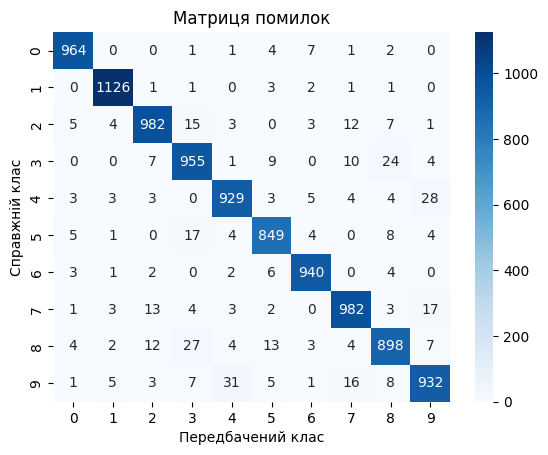

In [19]:
performance_evaluation(x_train_ae,x_test_ae)

### Performance evaluation - reduced data - only SVD

Час навчання mlp - 17.29539179801941
Час затрачений для передбачення всіх x_test(10000) - 0.01251983642578125 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 125.41 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



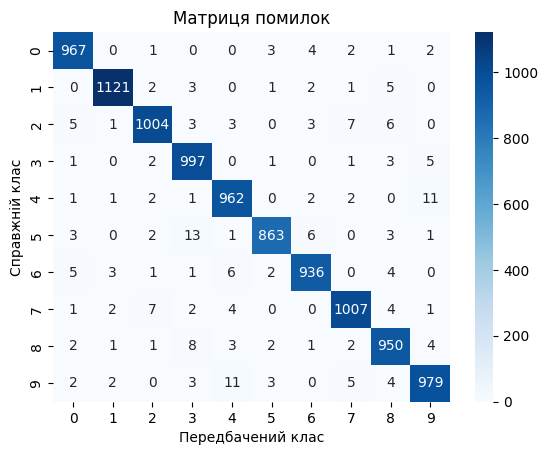

In [20]:
# note: use x train without AE
# performance_evaluation(x_train_svd,x_test_svd)

### Performance evaluation - reduced data

c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Час навчання mlp - 19.786543369293213
Час затрачений для передбачення всіх x_test(10000) - 0.010999679565429688 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 125.41 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.95      0.96      1032
           3       0.93      0.94      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.94      0.95      0.94       892
           6       0.97      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.92      0.92      0.92       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



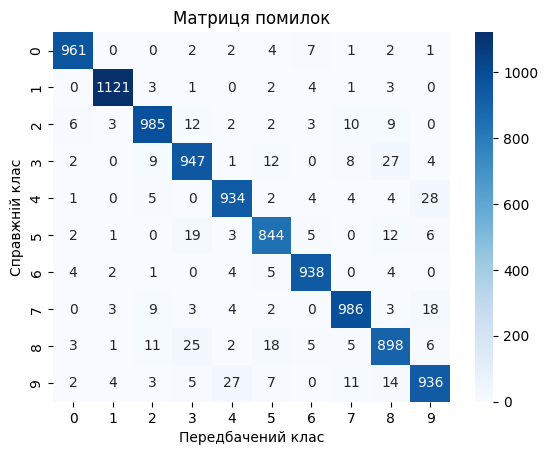

In [24]:
performance_evaluation(x_train_reduced,x_test_reduced)

### print all data size

In [45]:
x1 = sys.getsizeof(x_train)
x2 = sys.getsizeof(x_train_ae)
x3 = sys.getsizeof(x_train_reduced)
print(f"Розмір оригінальних даних       - { x1 } байт")
print(f"Розмір після автоенкодера       - { x2 } байт ({x2/x1})")
print(f"Розмір після автоенкодера + SVD - { x3 } байт ({x3/x2})")

Розмір оригінальних даних       - 188160144 байт
Розмір після автоенкодера       - 188160128 байт (0.9999999149660515)
Розмір після автоенкодера + SVD - 34560128 байт (0.1836740247115478)


# visualisation

In [43]:
x_ae = x_train_ae.reshape(len(x_train_ae), origin_dim, -1)
x_ae.shape

(60000, 28, 28)

In [44]:
X_recovered = svd.inverse_transform(x_train_svd)
x_svd = X_recovered.reshape(len(X_recovered), origin_dim, -1)
x_svd.shape

(60000, 28, 28)

In [45]:
x_svd_lat = x_train_svd.reshape(len(x_train_svd), lat_dim_svd, -1)
x_svd_lat.shape

(60000, 12, 12)

In [28]:
def plot_classes(x,y):
    unique_classes = np.unique(y)
    nrows, ncols = 1, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5), squeeze=False)

    # Для кожного унікального класу
    for i, digit_class in enumerate(unique_classes):
        row, col = i // ncols, i % ncols
        ax = axes[row][col]
        
        class_indices = np.where(y == digit_class)[0]
        digit_index = class_indices[0]
        digit_data = x[digit_index]
            
        ax.imshow(digit_data, cmap='gray')
        ax.set_title(f"Клас: {digit_class}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

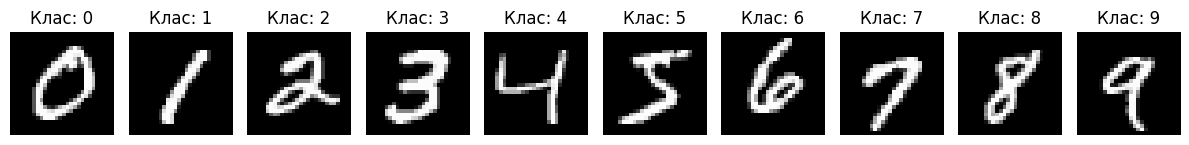

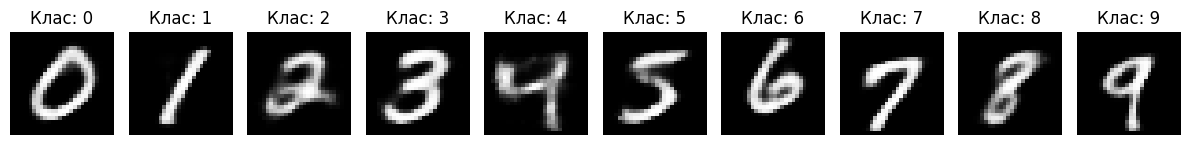

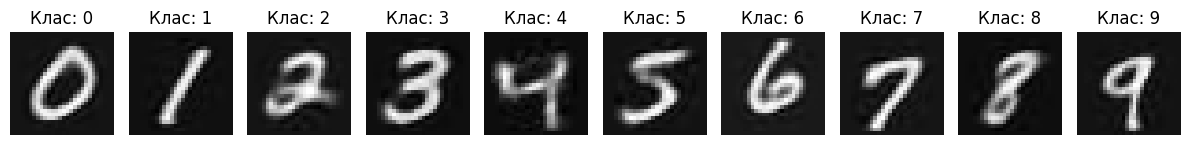

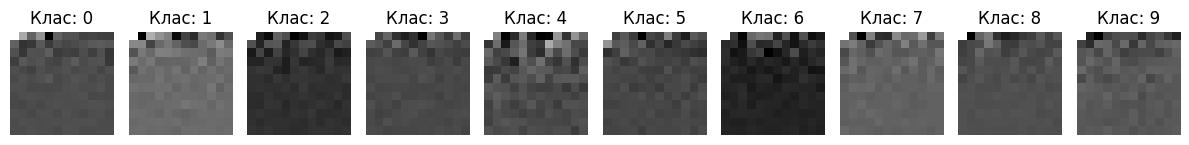

In [46]:
plot_classes(x_train,y_train)
plot_classes(x_ae,y_train)
plot_classes(x_svd,y_train) # after svd inverse
plot_classes(x_svd_lat,y_train) # clean svd

# Grig Search

In [38]:
steps = [
        #  ('AE', MyAE()),
         ('SVD', TruncatedSVD()),
         ('MLP', MLPClassifier())]
pipeline = Pipeline(steps)

param_grid = {
    # 'AE__lat_dim': [10, 15, 20, 30, 40],
    'SVD__n_components': list(range(10,200,10)),
    # 'SVD__n_components': [90]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=2)
grid_search.fit(x_train_flat, y_train)

results = pd.DataFrame(grid_search.cv_results_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


AttributeError: 'function' object has no attribute 'set_params'

In [29]:
# autoencoder = KerasRegressor(build_fn=create_autoencoder, verbose=0)

param_grid = dict(lat_dim=[10, 15, 20, 30, 40])
# grid = GridSearchCV(estimator=autoencoder, param_grid=param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=2)

tuner = RandomSearch(
    create_autoencoder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='autoencoders')

# Пошук найкращих гіперпараметрів
tuner.search(x_train_flat, x_train_flat, epochs=15, validation_data=(x_test_flat, x_test_flat))

# Отримання найкращої моделі
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 02m 43s]
val_loss: 0.03043809657295545

Best val_loss So Far: 0.007286400068551302
Total elapsed time: 00h 13m 45s


In [35]:
tuner.results_summary()

Results summary
Results in my_dir\autoencoders
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
lat_dim: 32
Score: 0.007286400068551302

Trial 3 summary
Hyperparameters:
lat_dim: 24
Score: 0.00957981962710619

Trial 0 summary
Hyperparameters:
lat_dim: 16
Score: 0.01200144737958908

Trial 1 summary
Hyperparameters:
lat_dim: 8
Score: 0.02051768700281779

Trial 4 summary
Hyperparameters:
lat_dim: 4
Score: 0.03043809657295545


In [36]:
results = pd.DataFrame(tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials)))
results

,0
0,<keras_tuner.src.engine.trial.Trial object at ...
1,<keras_tuner.src.engine.trial.Trial object at ...
2,<keras_tuner.src.engine.trial.Trial object at ...
3,<keras_tuner.src.engine.trial.Trial object at ...
4,<keras_tuner.src.engine.trial.Trial object at ...


In [ ]:
results

In [10]:
results2 = results[['param_SVD__n_components', 'mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
results2

,param_SVD__n_components,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
0,10,0.932283,19,24.035401,0.019807
1,20,0.967200,18,34.809402,0.018000
2,30,0.971317,17,35.184586,0.018999
3,40,0.973750,9,31.695084,0.019799
4,50,0.974400,6,24.229643,0.022514
5,60,0.974867,3,21.389501,0.023199
6,70,0.974667,5,23.943557,0.031987
7,80,0.974833,4,20.864032,0.029601
8,90,0.976100,1,21.589825,0.032141
9,100,0.974167,7,21.196146,0.034617


## charts

### svd

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


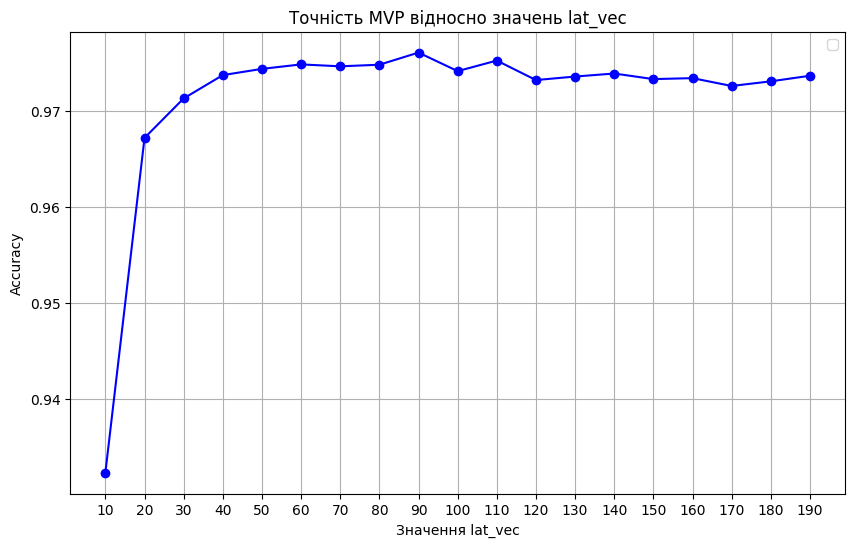

In [9]:
plt.figure(figsize=(10, 6))

plt.plot(results[['param_SVD__n_components']], results[['mean_test_score']], marker='o', color='blue')

plt.xlabel('Значення lat_vec')
plt.ylabel('Accuracy')
plt.title('Точність MVP відносно значень lat_vec')
plt.xticks(results['param_SVD__n_components'].tolist())
plt.grid(True)
plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


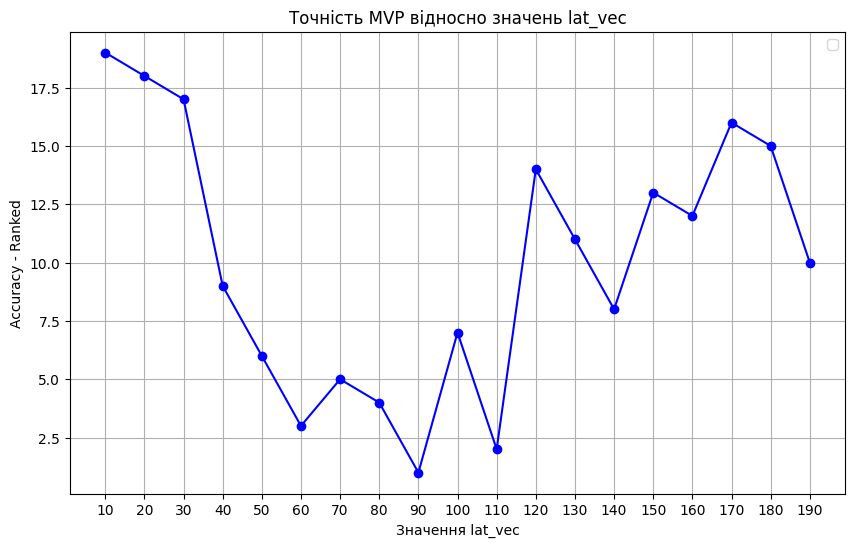

In [6]:
plt.figure(figsize=(10, 6))

plt.plot(results[['param_SVD__n_components']], results[['rank_test_score']], marker='o', color='blue')

plt.xlabel('Значення lat_vec')
plt.ylabel('Accuracy - Ranked')
plt.title('Точність MVP (Ranked) відносно значень lat_vec')
plt.xticks(results['param_SVD__n_components'].tolist())
plt.grid(True)
plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


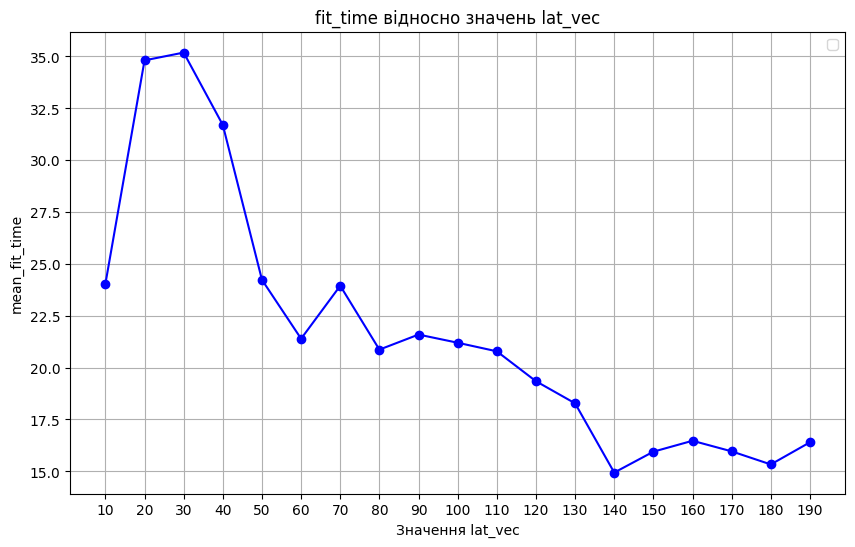

In [4]:
plt.figure(figsize=(10, 6))

plt.plot(results[['param_SVD__n_components']], results[['mean_fit_time']], marker='o', color='blue')

plt.xlabel('Значення lat_vec')
plt.ylabel('mean_fit_time')
plt.title('fit_time відносно значень lat_vec')
plt.xticks(results['param_SVD__n_components'].tolist())
plt.grid(True)
plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


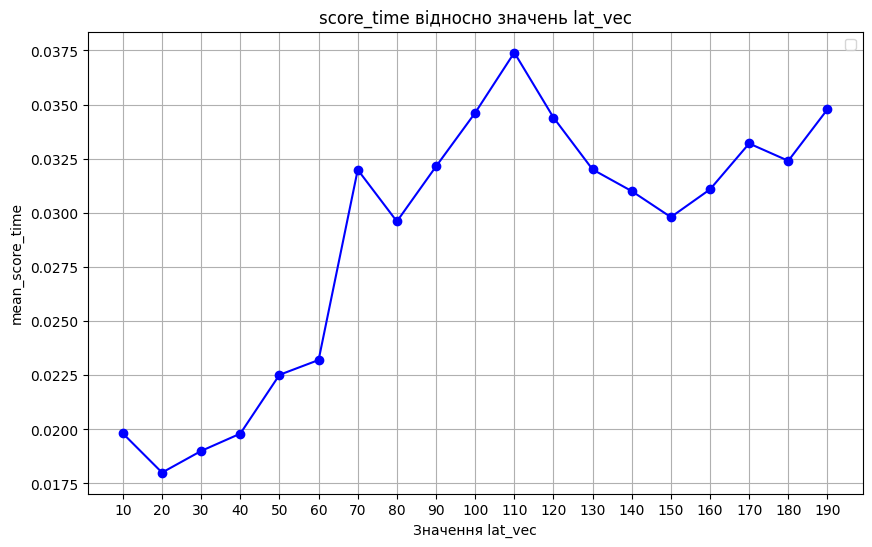

In [5]:
plt.figure(figsize=(10, 6))

plt.plot(results[['param_SVD__n_components']], results[['mean_score_time']], marker='o', color='blue')

plt.xlabel('Значення lat_vec')
plt.ylabel('mean_score_time')
plt.title('score_time відносно значень lat_vec')
plt.xticks(results['param_SVD__n_components'].tolist())
plt.grid(True)
plt.legend()

plt.show()

### AE

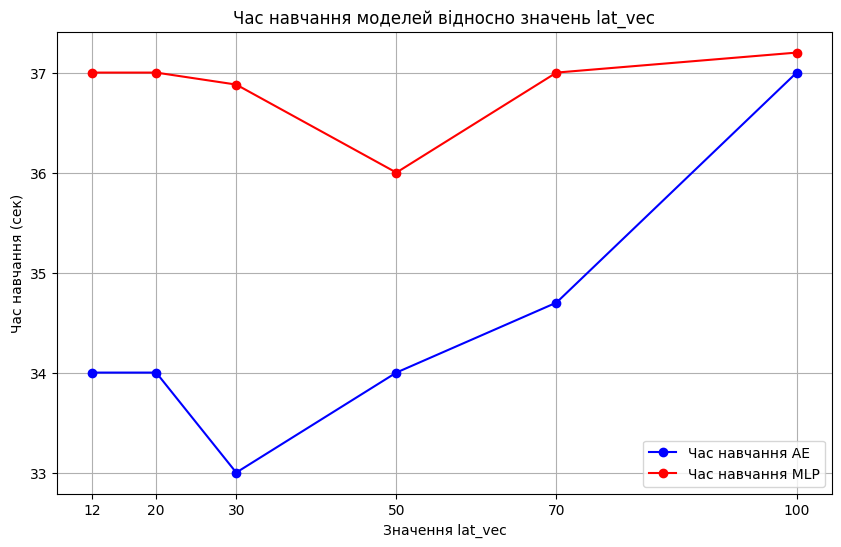

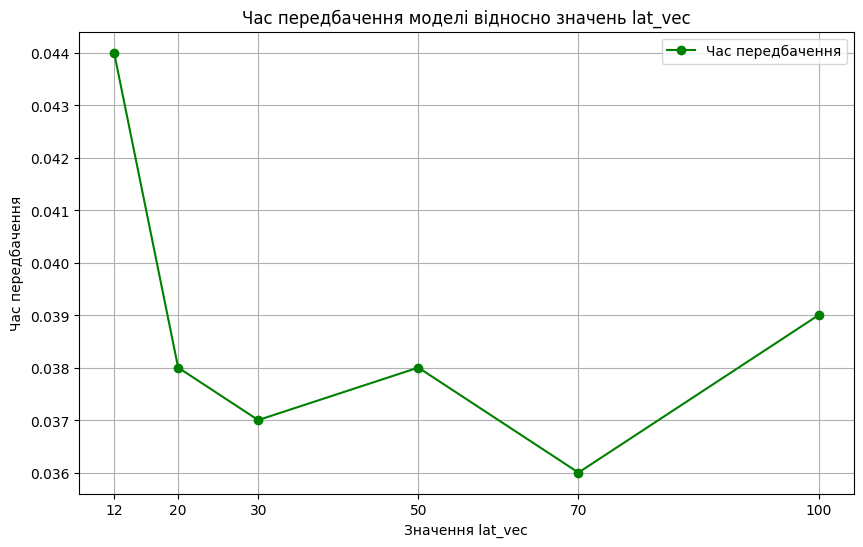

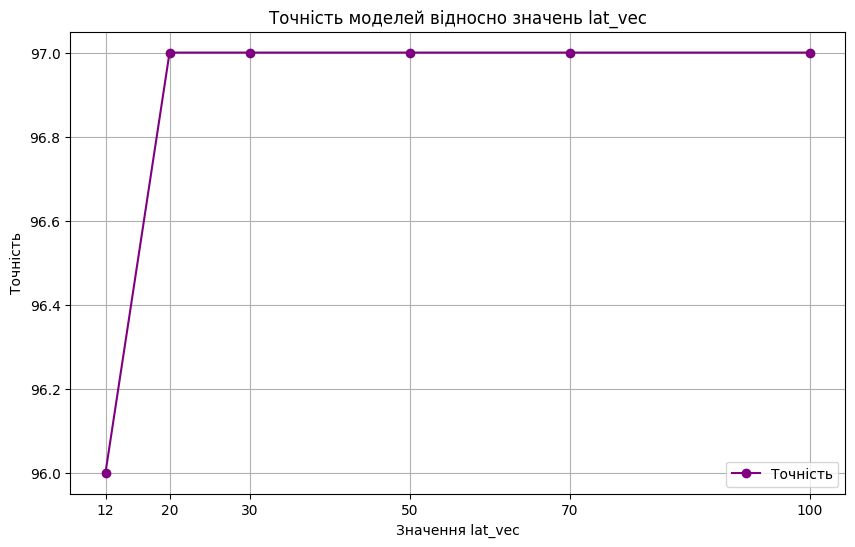

In [ ]:
import matplotlib.pyplot as plt

# Значення параметрів
lat_vec =           [12, 20, 30, 50, 70, 100]
ae_training_time =  [34, 34, 33, 34, 34.7, 37]  # Час навчання AE
mlp_training_time = [37, 37, 36.88, 36, 37, 37.2]  # Час навчання MLP
prediction_time =   [0.044, 0.038, 0.037, 0.038, 0.036, 0.039]  # Час передбачення
accuracy =          [96, 97, 97, 97, 97, 97]  # Точність

# Побудова графіку для часу навчання AE та MLP
plt.figure(figsize=(10, 6))

plt.plot(lat_vec, ae_training_time, marker='o', color='blue', label='Час навчання AE')
plt.plot(lat_vec, mlp_training_time, marker='o', color='red', label='Час навчання MLP')

plt.xlabel('Значення lat_vec')
plt.ylabel('Час навчання (сек)')
plt.title('Час навчання моделей відносно значень lat_vec')
plt.xticks(lat_vec)
plt.grid(True)
plt.legend()

plt.show()

# Побудова графіку для часу передбачення
plt.figure(figsize=(10, 6))

plt.plot(lat_vec, prediction_time, marker='o', color='green', label='Час передбачення')

plt.xlabel('Значення lat_vec')
plt.ylabel('Час передбачення')
plt.title('Час передбачення моделі відносно значень lat_vec')
plt.xticks(lat_vec)
plt.grid(True)
plt.legend()

plt.show()

# Побудова графіку для точності
plt.figure(figsize=(10, 6))


plt.plot(lat_vec, accuracy, marker='o', color='purple', label='Точність')

plt.xlabel('Значення lat_vec')
plt.ylabel('Точність')
plt.title('Точність моделей відносно значень lat_vec')
plt.xticks(lat_vec)
plt.grid(True)
plt.legend()

plt.show()


# TODO 
- як впливає автоенкодер - не дуже добре
- доп. алгоритими до пайплайну - pass
- різні методи оцінки якості редукції +
    - розмір даних після редукції +
    - модель:
        - час навчання +
        - швидкість відгуку моделі +
        - розмір моделі на диску +
        - розмір моделі в оперативці +

- архітектура AE +
    - + оригінал ae (12lat): 
        - час навчання AE  - 34 
        - час навчання mlp - 37 
        - час передбачення - 0.044 
        - точність         - 0.96
    - + 1 прихований шар: 
        - час навчання AE  - 30 
        - час навчання mlp - 36.2 
        - час передбачення - 0.036 
        - точність         - 0.95
    - + 2 приховані шари: 
        - час навчання AE  - 29 
        - час навчання mlp - 38 
        - час передбачення - 0.044 
        - точність         - 0.96

- gridsearch для пайплайну
    - AE збільшити кількість latt vec +
    - підібрати параметри для SVD, зробити графік (звітність) +

- AE в gridsearch +-

- дослідити для яких алгоритмів (дерева рішень, класифікація) ми отримаємо перевагу від редукції

---
дані після SVD захищені (шифрування)
На майбутнє: робота з RGB

https://www.kaggle.com/code/jonathankristanto/experimenting-with-pca-on-mnist-dataset